In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.6.0


In [33]:
# df=pd.read_excel('appdata.xlsx')

In [55]:
df=pd.read_csv('test_appdata.csv')

In [56]:
df.head()

,timeElapsed,x,y,z,label
0,0,0.75,-9.53,1.04,Standing
1,1,0.76,-9.55,1.05,Standing
2,2,0.77,-9.53,1.05,Standing
3,3,0.80,-9.53,1.01,Standing
4,4,0.87,-9.55,1.03,Standing


In [57]:
df['label'].value_counts()

Walking       100033
Sitting        91000
Upstairs       66095
Downstairs     42443
Standing       42353
Name: label, dtype: int64

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
label = LabelEncoder()
df['ActivityLabel'] = label.fit_transform(df['label'])
df.tail()

,timeElapsed,x,y,z,label,ActivityLabel
341919,341919,1.13,-0.77,9.86,Standing,2
341920,341920,1.91,0.20,10.12,Standing,2
341921,341921,2.53,1.34,10.42,Standing,2
341922,341922,1.75,0.68,9.61,Standing,2
341923,341923,1.84,1.27,10.54,Standing,2


In [60]:
label.classes_



array(['Downstairs', 'Sitting', 'Standing', 'Upstairs', 'Walking'],
      dtype=object)

### Standardized data 

In [61]:
X = df[['x', 'y', 'z']]
y = df['ActivityLabel']

In [62]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['ActivityLabel'] = y.values

scaled_X

,x,y,z,ActivityLabel
0,-0.477386,-0.959055,0.105813,2
1,-0.475363,-0.962177,0.107647,2
2,-0.473341,-0.959055,0.107647,2
3,-0.467273,-0.959055,0.100313,2
4,-0.453115,-0.962177,0.103980,2
...,...,...,...,...
341919,-0.400528,0.408408,1.723041,2
341920,-0.242768,0.559828,1.770715,2
341921,-0.117368,0.737785,1.825723,2
341922,-0.275129,0.634757,1.677202,2


### Frame Preparation 

In [63]:
Fs = 50
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [64]:
def get_frames(df, frame_size, hop_size):
    N_FEATURES = 3
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        # Retrieve the most often used label in this segment
        label = stats.mode(df['ActivityLabel'][i: i + frame_size])[0][0]

        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [65]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [46]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 3, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 3, 1)

In [47]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [48]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [49]:
history = model.fit(X_train, y_train, epochs = 40, validation_data= (X_test, y_test), verbose=1)

Epoch 1/40
179/179 [==============================] - 2s 12ms/step - loss: 0.7930 - accuracy: 0.6986 - val_loss: 0.5958 - val_accuracy: 0.7584
Epoch 2/40
179/179 [==============================] - 2s 11ms/step - loss: 0.6180 - accuracy: 0.7517 - val_loss: 0.5313 - val_accuracy: 0.7910
Epoch 3/40
179/179 [==============================] - 2s 12ms/step - loss: 0.5596 - accuracy: 0.7786 - val_loss: 0.5052 - val_accuracy: 0.8036
Epoch 4/40
179/179 [==============================] - 2s 12ms/step - loss: 0.5149 - accuracy: 0.7915 - val_loss: 0.5037 - val_accuracy: 0.8085
Epoch 5/40
179/179 [==============================] - 2s 11ms/step - loss: 0.4832 - accuracy: 0.8097 - val_loss: 0.4786 - val_accuracy: 0.8166
Epoch 6/40
179/179 [==============================] - 2s 12ms/step - loss: 0.4634 - accuracy: 0.8143 - val_loss: 0.4764 - val_accuracy: 0.8215
Epoch 7/40
179/179 [==============================] - 2s 12ms/step - loss: 0.4441 - accuracy: 0.8200 - val_loss: 0.4711 - val_accuracy: 0.8223

In [50]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [51]:
pred = model.predict(X_test, batch_size = 32)
pred = np.argmax(pred, axis=1)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1850f0e1c48>)

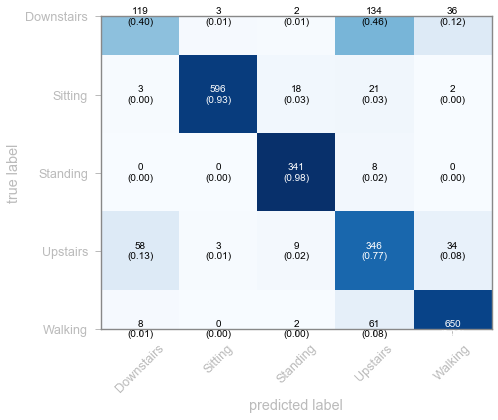

In [52]:
import seaborn as sns
mat = confusion_matrix(y_test, pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [53]:
score = model.evaluate(X_test, pred, verbose=0)
print("test loss, test acc:", score)

test loss, test acc: [0.1390361338853836, 1.0]


In [54]:
from sklearn.metrics import  accuracy_score

print('Accuracy --------->',round(accuracy_score(y_test, pred),2))

Accuracy ---------> 0.84


### Accuracy of independet data


In [66]:
X = X.reshape(X.shape[0], X.shape[1], 3, 1)

In [67]:
pred = model.predict(X, batch_size = 32)
pred = np.argmax(pred, axis=1)

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1850f765848>)

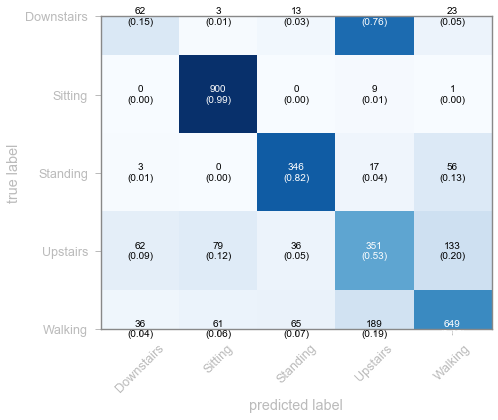

In [68]:
mat = confusion_matrix(y, pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7,7))

In [70]:
from sklearn.metrics import  accuracy_score

print('Accuracy dependent --------->',round(accuracy_score(y, pred),2))

Accuracy dependent ---------> 0.68
